<a href="https://colab.research.google.com/github/Abhishek734/image_segmentation/blob/master/Mask_R_CNN_for_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implementing Mask R-CNN for Image Segmentation

1. We take an image as input and pass it to the ConvNet, which returns the feature map for that image

2. Region proposal network (RPN) is applied on these feature maps. This returns the object proposals along with their objectness score

3. A RoI pooling layer is applied on these proposals to bring down all the proposals to the same size

4. Finally, the proposals are passed to a fully connected layer to classify and output the bounding boxes for objects. It also returns the mask for each proposal

Let’s first quickly understand how Faster R-CNN works. This will help us grasp the intuition behind Mask R-CNN as well.

* Faster R-CNN first uses a ConvNet to extract feature maps from the images

* These feature maps are then passed through a Region Proposal Network (RPN) which returns the candidate bounding boxes
* We then apply an RoI pooling layer on these candidate bounding boxes to bring all the candidates to the same size
* And finally, the proposals are passed to a fully connected layer to classify and output the bounding boxes for objects


### Backbone Model
Similar to the ConvNet that we use in Faster R-CNN to extract feature maps from the image, we use the ResNet 101 architecture to extract features from the images in Mask R-CNN. So, the first step is to take an image and extract features using the ResNet 101 architecture. These features act as an input for the next layer.

 

### Region Proposal Network (RPN)
Now, we take the feature maps obtained in the previous step and apply a region proposal network (RPM). This basically predicts if an object is present in that region (or not). In this step, we get those regions or feature maps which the model predicts contain some object.

 

### Region of Interest (RoI)
The regions obtained from the RPN might be of different shapes, right? Hence, we apply a pooling layer and convert all the regions to the same shape. Next, these regions are passed through a fully connected network so that the class label and bounding boxes are predicted.

Till this point, the steps are almost similar to how Faster R-CNN works. Now comes the difference between the two frameworks. In addition to this, **Mask R-CNN also generates the segmentation mask**.

For that, we first compute the region of interest so that the computation time can be reduced. For all the predicted regions, we compute the Intersection over Union (IoU) with the ground truth boxes. We can computer IoU like this:

IoU = Area of the intersection / Area of the union

Now, only if the IoU is greater than or equal to 0.5, we consider that as a region of interest. Otherwise, we neglect that particular region. We do this for all the regions and then select only a set of regions for which the IoU is greater than 0.5.

Install Matterport's Mask-RCNN model from github.
See the [Matterport's implementation of Mask-RCNN](https://https://github.com/matterport/Mask_RCNN).



In [1]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.90 MiB | 33.83 MiB/s, done.
Resolving deltas: 100% (571/571), done.


## Download COCO pre-trained weights

In [5]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


## import librabries

In [0]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

In [0]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../")

In [17]:
ROOT_DIR

'/content/Mask_RCNN'

In [0]:
# import shutil
# shutil.copyfile("/content/mask_rcnn_coco.h5", "/content/Mask_RCNN/samples/")


In [21]:
import warnings
warnings.filterwarnings("ignore")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline

Using TensorFlow backend.


In [0]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join('/content', "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

In [23]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Loading weights

In [25]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir='mask_rcnn_coco.hy', config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [24]:
COCO_MODEL_PATH

'/content/mask_rcnn_coco.h5'

In [0]:
# COCO Class names
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [27]:
len(class_names)

81

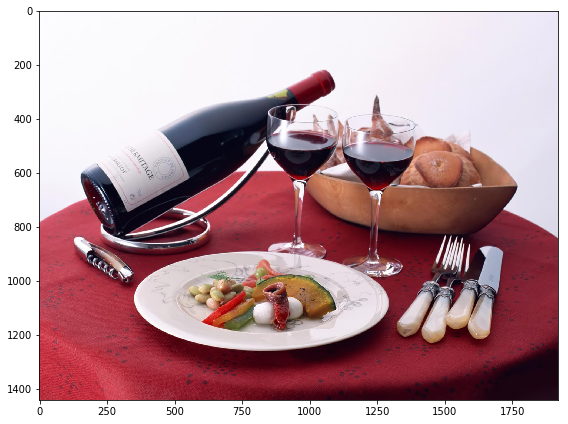

In [48]:
# Load a random image from the images folder
image = skimage.io.imread('286424.jpg')

# original image
plt.figure(figsize=(8,8))
skimage.io.imshow(image)

## Making Predictions

Processing 1 images
image                    shape: (1440, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


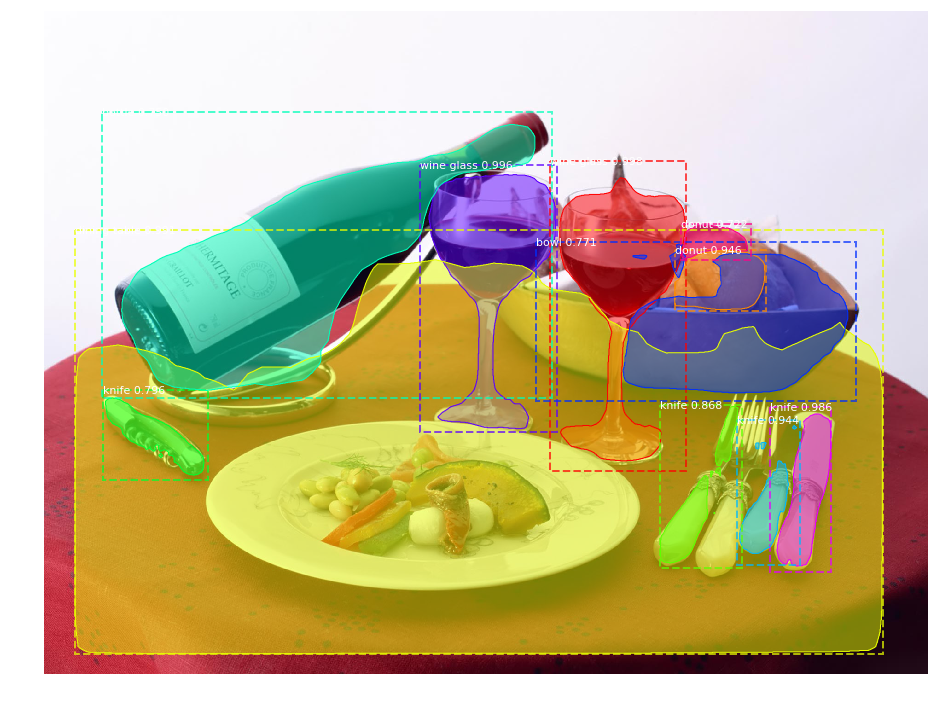

In [49]:
# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

In [50]:
mask = r['masks']
mask = mask.astype(int)
mask.shape

(1440, 1920, 11)

Note that the shape of the mask is similar to that of the original image (you can verify that by printing the shape of the original image).

the 3 here in the shape of the mask does not represent the channels. Instead, it represents the number of objects segmented by our model. Since the model has identified 3 objects in the above sample image

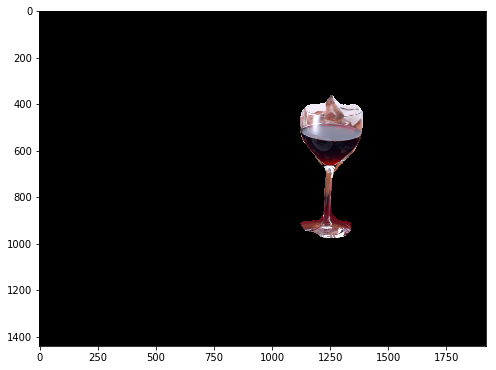

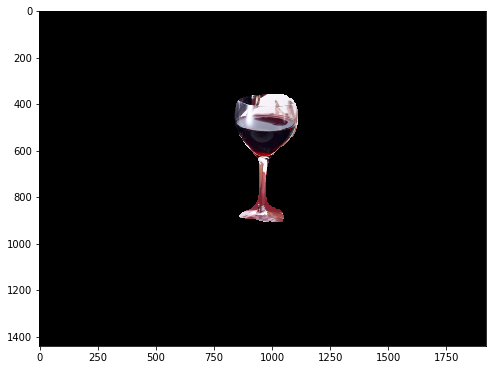

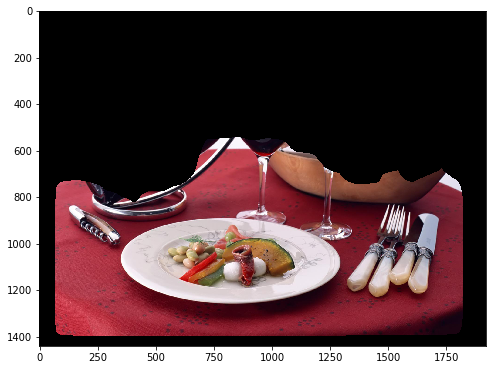

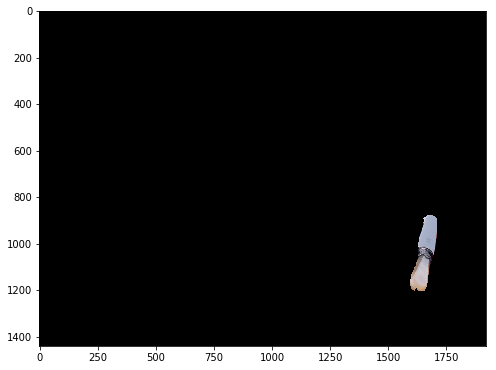

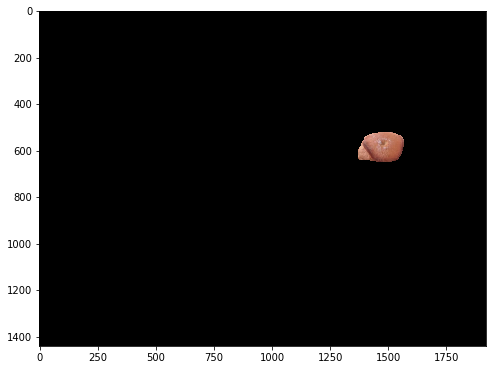

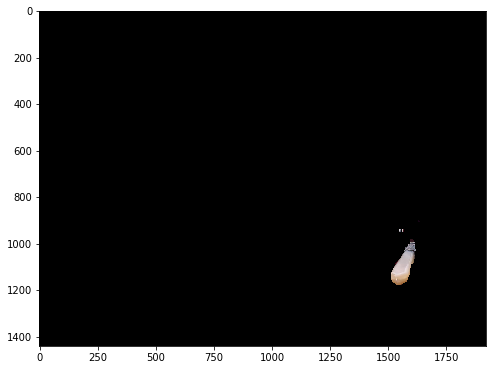

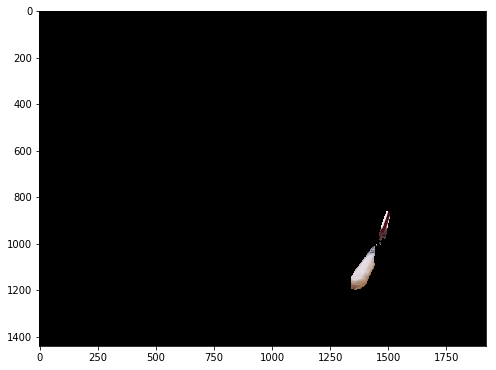

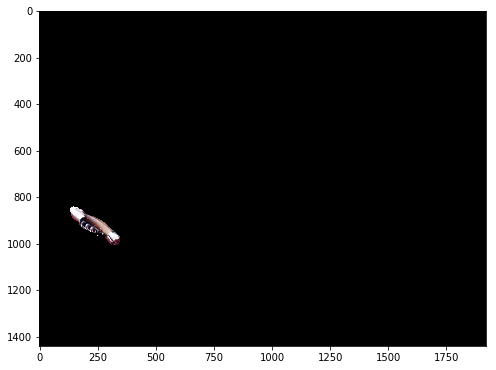

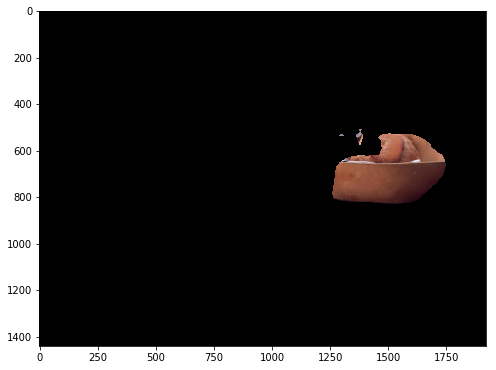

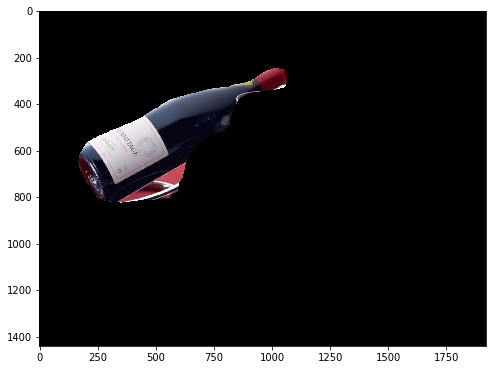

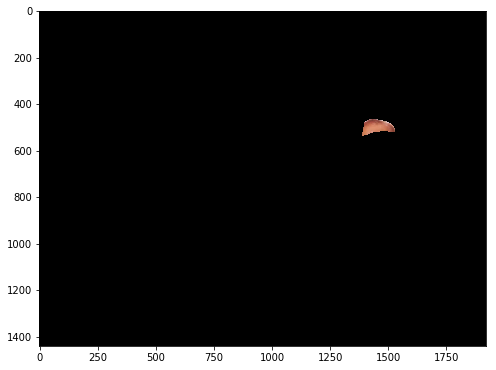

In [51]:
for i in range(mask.shape[2]):
    temp = skimage.io.imread('286424.jpg')
    for j in range(temp.shape[2]):
        temp[:,:,j] = temp[:,:,j] * mask[:,:,i]
    plt.figure(figsize=(8,8))
    plt.imshow(temp)